# Участок для будущего переноса. Он делался для построения красивых графиков.

## Краткое пояснение

В этом ноутбуке показан пример анализа перенапряжений на основе CSV-файла. Основные шаги, выполняемые в нотаутке:

- Подготовка и фильтрация данных (оставляем строки с признаком проверки = '+');
- Визуализация распределения (KDE) и кумулятивной функции (CDF);
- Получение базовой статистики и дополнительные диаграммы (Box/Violin).

Путь к примеру в коде: `raw_data/overvoltage_report_T1_with_com_v1.7.csv`. При необходимости замените путь на ваш файл.

Для подробной логики выделения и обработки перенапряжений можно посмотреть модуль `osc_tools.analysis.overvoltage` (файл `osc_tools/analysis/overvoltage.py`).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd

import os

--- 1. Построение графика плотности вероятности (KDE) ---


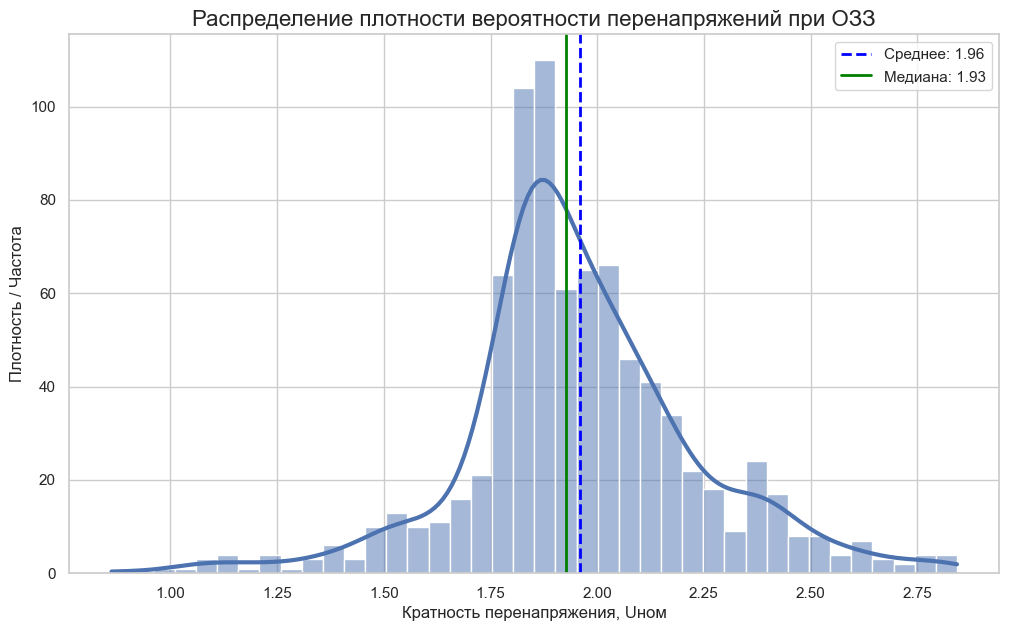

In [2]:
# --- 0. Подготовка данных ---
# В реальном коде вы будете читать файл: df = pd.read_csv('your_file.csv', sep=';')
# Здесь мы используем предоставленный вами фрагмент данных.

# Получаем текущий рабочий каталог ноутбука
notebook_dir = os.getcwd()
# Выход на исходный коталог
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))
source_example_dir = os.path.join(project_root, "raw_data", "overvoltage_report_T1_with_com_v1.7.csv")

df = pd.read_csv(source_example_dir, sep=';')

# 1) Фильтруем данные: оставляем только строки, где "Проверка" == "+"
df_filtered = df[df['Проверка'] == '+'].copy()

# 2) Преобразуем столбец 'overvoltage' в числовой формат, чтобы избежать ошибок
df_filtered['overvoltage'] = pd.to_numeric(df_filtered['overvoltage'])

# Устанавливаем стиль для графиков, чтобы они выглядели профессионально
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Устанавливаем размер графиков

# --- 1. График плотности распределения (KDE) ---
# Это современная и красивая альтернатива гистограмме со сглаживающей кривой.
# Она показывает, где концентрируется большинство ваших событий.

print("--- 1. Построение графика плотности вероятности (KDE) ---")

plt.figure() # Создаем новую фигуру для графика
kde_plot = sns.histplot(df_filtered['overvoltage'], kde=True, bins=40,
                        line_kws={'linewidth': 3, 'color': 'red'})

# Добавляем вертикальные линии для среднего и медианы
plt.axvline(df_filtered['overvoltage'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Среднее: {df_filtered["overvoltage"].mean():.2f}')
plt.axvline(df_filtered['overvoltage'].median(), color='green', linestyle='-', linewidth=2, label=f'Медиана: {df_filtered["overvoltage"].median():.2f}')

kde_plot.set_title('Распределение плотности вероятности перенапряжений при ОЗЗ', fontsize=16)
kde_plot.set_xlabel('Кратность перенапряжения, Uном', fontsize=12)
kde_plot.set_ylabel('Плотность / Частота', fontsize=12)
plt.legend()
plt.show()



--- 2. Построение графика кумулятивного распределения (CDF) ---


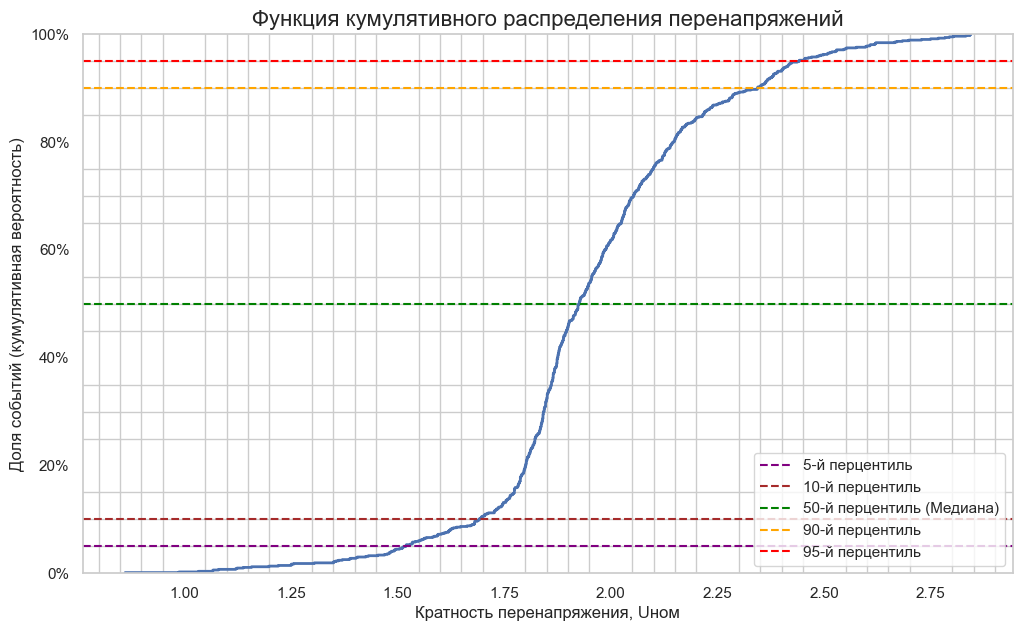

In [3]:
# --- 2. Эмпирическая функция кумулятивного распределения (CDF) ---
# Этот график отвечает на вопрос: "Какой процент событий имеет перенапряжение МЕНЬШЕ или РАВНО X?"
# Он очень важен для оценки вероятностей и рисков.

print("\n--- 2. Построение графика кумулятивного распределения (CDF) ---")

plt.figure()
cdf_plot = sns.ecdfplot(df_filtered['overvoltage'], linewidth=2)

# Форматируем ось Y в проценты для наглядности
cdf_plot.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Добавим важные перцентили (5%, 10%, медиана, 90%, 95%)
plt.axhline(0.05, color='purple', linestyle='--', linewidth=1.5, label='5-й перцентиль')
plt.axhline(0.10, color='brown', linestyle='--', linewidth=1.5, label='10-й перцентиль')
plt.axhline(0.50, color='green', linestyle='--', linewidth=1.5, label='50-й перцентиль (Медиана)')
plt.axhline(0.90, color='orange', linestyle='--', linewidth=1.5, label='90-й перцентиль')
plt.axhline(0.95, color='red', linestyle='--', linewidth=1.5, label='95-й перцентиль')

cdf_plot.set_title('Функция кумулятивного распределения перенапряжений', fontsize=16)
cdf_plot.set_xlabel('Кратность перенапряжения, Uном', fontsize=12)
cdf_plot.set_ylabel('Доля событий (кумулятивная вероятность)', fontsize=12)
plt.legend(loc='lower right')
plt.minorticks_on()
plt.grid(which='both')
plt.show()

In [4]:
# --- 3. Базовая статистическая оценка в виде таблицы ---
# Считаем основные статистические показатели и выводим их в удобном виде.

print("\n--- 3. Базовая статистическая оценка выборки ---")

stats_series = df_filtered['overvoltage'].describe()
# Добавляем дополнительные полезные метрики
stats_series['median'] = df_filtered['overvoltage'].median()
stats_series['variance'] = df_filtered['overvoltage'].var()

# Формируем красивый DataFrame для вывода
stats_df = pd.DataFrame({
    'Показатель': [
        'Количество наблюдений',
        'Среднее арифметическое',
        'Медиана (50-й перцентиль)',
        'Стандартное отклонение',
        'Дисперсия',
        'Минимальное значение',
        '25-й перцентиль (Q1)',
        '75-й перцентиль (Q3)',
        'Максимальное значение'
    ],
    'Значение': [
        stats_series['count'],
        stats_series['mean'],
        stats_series['median'],
        stats_series['std'],
        stats_series['variance'],
        stats_series['min'],
        stats_series['25%'],
        stats_series['75%'],
        stats_series['max']
    ]
})

# Выводим таблицу, отформатировав числа до 3 знаков после запятой
print(stats_df.to_string(index=False, float_format='%.3f'))


--- 3. Базовая статистическая оценка выборки ---
               Показатель  Значение
    Количество наблюдений   830.000
   Среднее арифметическое     1.960
Медиана (50-й перцентиль)     1.926
   Стандартное отклонение     0.274
                Дисперсия     0.075
     Минимальное значение     0.862
     25-й перцентиль (Q1)     1.823
     75-й перцентиль (Q3)     2.099
    Максимальное значение     2.843



--- 4. Дополнительные визуализации: Box Plot и Violin Plot ---


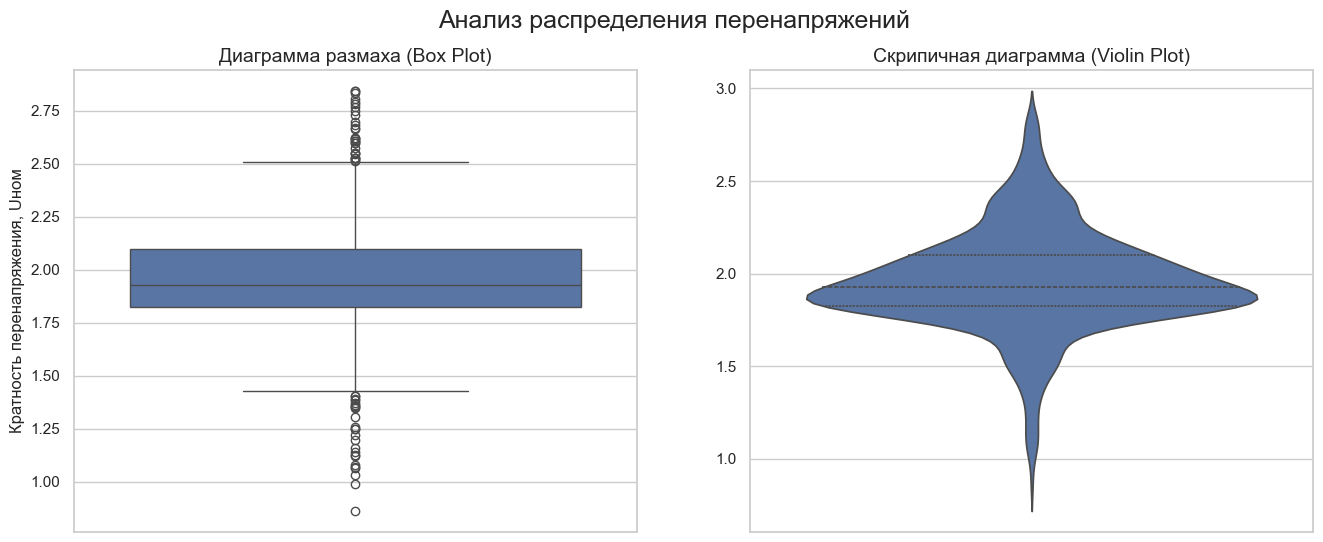

In [ ]:
# --- 4. Дополнительная идея: Box Plot и Violin Plot ---
# Эти графики отлично показывают разброс данных, медиану, межквартильный размах и выбросы.
# Violin plot совмещает в себе Box plot и KDE, что делает его очень информативным.

print("\n--- 4. Дополнительные визуализации: Box Plot и Violin Plot ---")

fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # Создаем 2 графика рядом

# Box Plot (Ящик с усами)
sns.boxplot(y=df_filtered['overvoltage'], ax=axes[0])
axes[0].set_title('Диаграмма размаха (Box Plot)', fontsize=14)
axes[0].set_ylabel('Кратность перенапряжения, Uном', fontsize=12)

# Violin Plot (Скрипичная диаграмма)
sns.violinplot(y=df_filtered['overvoltage'], ax=axes[1], inner='quartile')
axes[1].set_title('Скрипичная диаграмма (Violin Plot)', fontsize=14)
axes[1].set_ylabel('') # Убираем дублирующуюся подпись

fig.suptitle('Анализ распределения перенапряжений', fontsize=18)
plt.show()

## Заключение и дальнейшие шаги

Это локальный пример с одной задачей; далее сюда можно добавить необходимые вам сценарии и расширения.

Данный раздел будет постепенно расширяться и/или разделяться на подразделы под разные задачи — добавляйте свои идеи и примеры, и мы их интегрируем.